In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from os.path import dirname, abspath, join
from os import listdir
import librosa


### Read Data from files

In [61]:
# if hasattr(self, __file__):
#     cur_dir = dirname(abspath(__file__))
# else:
#     cur_dir = dirname(abspath(''))
cur_dir = abspath("")
data = pd.DataFrame(columns=['path', 'speaker', 'number'])
data_path = join(cur_dir, 'Audio')
for dir in listdir(data_path):
    number_dir = join(data_path, dir)
    for audio in listdir(number_dir):
        new_data = {'path': join(number_dir, audio), 'speaker': audio.split("_")[1], 'number': int(dir)}
        data = data._append(new_data, ignore_index=True)

data.head()

,path,speaker,number
0,f:\EDU\Data science\Projects\speech_mnist\Audi...,george,0
1,f:\EDU\Data science\Projects\speech_mnist\Audi...,george,0
2,f:\EDU\Data science\Projects\speech_mnist\Audi...,george,0
3,f:\EDU\Data science\Projects\speech_mnist\Audi...,george,0
4,f:\EDU\Data science\Projects\speech_mnist\Audi...,george,0


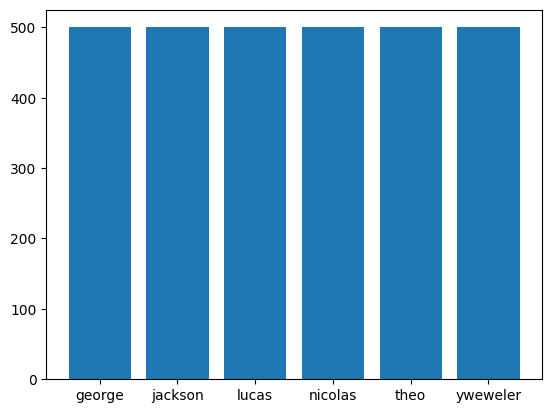

In [108]:
speaker_data = data.groupby(by='speaker')['number'].count()
plt.bar(x=speaker_data.index, height=speaker_data.values)
plt.show()

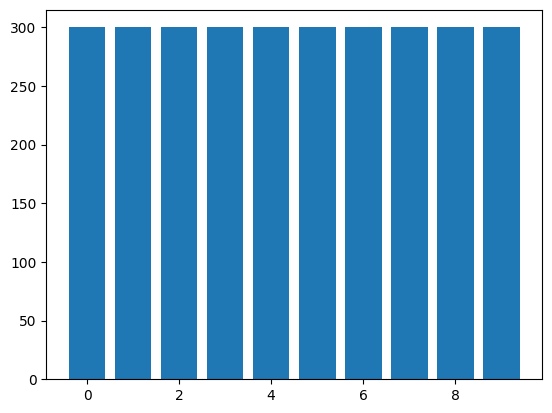

In [111]:
number_data = data.groupby(by='number')['speaker'].count()
plt.bar(x=number_data.index, height=number_data.values)
plt.show()

### Read a sample and its spectogram

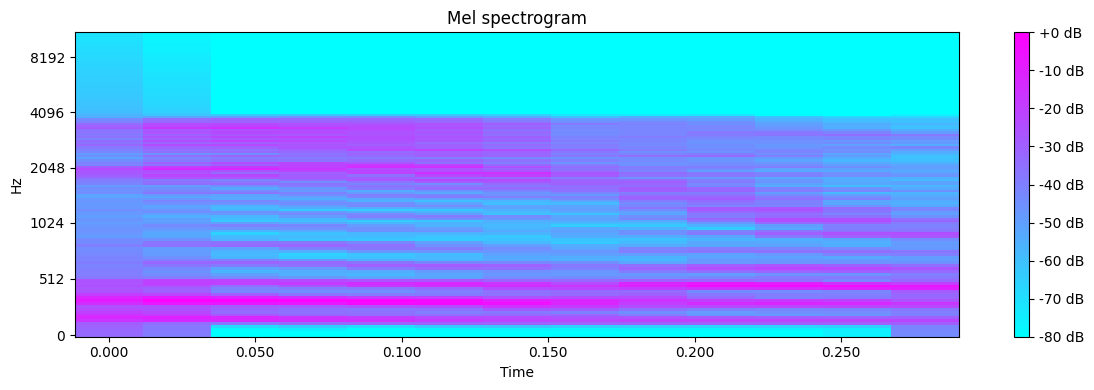

In [64]:
y, sr = librosa.load(data.iloc[0]['path'])
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel',  cmap='cool')
plt.title('Mel spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

### read and convert all data into spectogram

In [62]:
data_list = []
target_list = []
for path, speaker, number in data.itertuples(index=False):
    y, sr = librosa.load(data.iloc[0]['path'])
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    img = ((log_S - log_S.min()) / (log_S.max() - log_S.min()) * 255).astype(np.uint8)
    data_list.append(img)
    target_list.append(number)

In [63]:
data_list[0].shape, data_list[1].shape

((128, 13), (128, 13))

In [67]:
data_list = np.array(data_list)
target_list = np.array(target_list)

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_list, target_list, test_size=0.2, random_state=42) 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2400, 128, 13), (600, 128, 13), (2400,), (600,))

In [75]:
X_train.shape[0]

2400

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, GlobalAveragePooling2D, Dropout, AveragePooling2D
from tensorflow.keras.utils import to_categorical

In [81]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [86]:
sixth_cnn = Sequential()
sixth_cnn.add(Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=(128, 13, 1)))    # 3rd dim = 1 for grayscale images.
sixth_cnn.add(AveragePooling2D(pool_size=(2,2)))
sixth_cnn.add(Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
sixth_cnn.add(AveragePooling2D(pool_size=(2,2)))
# sixth_cnn.add(GlobalAveragePooling2D())
sixth_cnn.add(Flatten())
sixth_cnn.add(Dense(128, activation='relu'))
sixth_cnn.add(Dropout(0.25))
sixth_cnn.add(Dense(64, activation='relu'))
sixth_cnn.add(Dense(10, activation='softmax'))
sixth_cnn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 128, 13, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 64, 6, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 6, 64)      │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 32, 3, 64)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       786,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 847,562 (3.23 MB)

 Trainable params: 847,562 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
sixth_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_history = sixth_cnn.fit(X_train,
                                y_train,
                                batch_size=512,
                                validation_data=(X_test,y_test),
                                epochs=60,
                                shuffle=False  
                                )

Epoch 1/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 591ms/step - accuracy: 0.1034 - loss: 9.4960 - val_accuracy: 0.0933 - val_loss: 2.5531
Epoch 2/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - accuracy: 0.0949 - loss: 2.6592 - val_accuracy: 0.0933 - val_loss: 2.3033
Epoch 3/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.0957 - loss: 2.3202 - val_accuracy: 0.0933 - val_loss: 2.3043
Epoch 4/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 0.1045 - loss: 2.3050 - val_accuracy: 0.1050 - val_loss: 2.3044
Epoch 5/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - accuracy: 0.0895 - loss: 2.3027 - val_accuracy: 0.0933 - val_loss: 2.3050
Epoch 6/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - accuracy: 0.0907 - loss: 2.3023 - val_accuracy: 0.0933 - val_loss: 2.3055
Epoch 7/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.0890 - loss: 2.3029 - val_accuracy: 0.0933 - val_loss: 2.3052
Epoch 8/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - accuracy: 0.1097 - loss: 2.3028 - val_accuracy: 0.0933 - val_loss: